In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

c:\Users\debon\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.ToTensor()

traindataset = datasets.FashionMNIST('./downloads/', download=True, train=True, transform=transform)
testdataset = datasets.FashionMNIST('./downloads/', download=True, train=False, transform=transform)

In [3]:
bs =1000
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=bs, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=bs, shuffle=False, num_workers=4)

In [4]:
len(testdataset.classes)
     

10

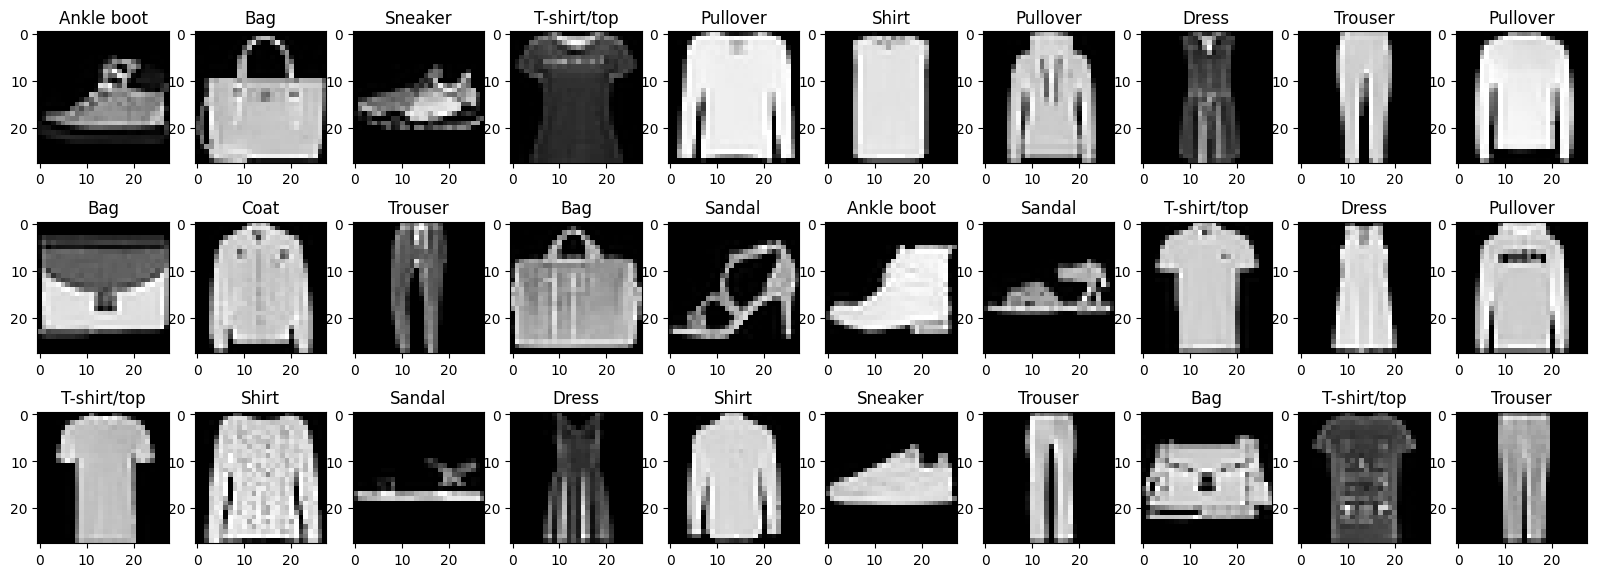

In [5]:
def view_samples():
    
    test_images, labels = next(iter(testloader))

    fig = plt.figure(figsize =(20,7))
    nrows = 3
    ncols = 10
    b=np.random.randint(0,test_images.shape[0]-nrows*ncols)
    for i in range(nrows*ncols):
        inp = test_images.view(-1, 28, 28)
        plot = fig.add_subplot(nrows, ncols, i+1)
        plot.set_title(testdataset.classes[labels[i+b].cpu().numpy()])
        imgplot = plt.imshow(inp[i+b].cpu(), cmap='gray')
    plt.show()
view_samples()

In [6]:

class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        )
    self.decoder = nn.Sequential(
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 784),
        nn.ReLU()
        )
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x
     

In [7]:

model = AutoEncoder()

In [8]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): ReLU()
  )
)

In [9]:
optimizer =  torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [10]:
epochs = 20
noise_factor =0.2
for epoch in range(epochs):
  train_loss = 0.0
  
  for images, labels in trainloader:
    ## add random noise to the input images
    noisy_imgs = images + noise_factor * torch.randn(*images.shape)
    # Clip the images to be between 0 and 1
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
            
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    ## forward pass: compute predicted outputs by passing *noisy* images to the model
    outputs = model(noisy_imgs.view(-1,784))
    # calculate the loss
    # the "target" is still the original, not-noisy images
    loss = criterion(outputs, images.view(-1,784))
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    # update running training loss
    train_loss += loss.item()*images.size(0)

  # print avg training statistics 
  train_loss = train_loss/len(trainloader)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

Epoch: 1 	Training Loss: 116.672702
Epoch: 2 	Training Loss: 85.431777
Epoch: 3 	Training Loss: 55.942011
Epoch: 4 	Training Loss: 47.792228
Epoch: 5 	Training Loss: 43.616184
Epoch: 6 	Training Loss: 39.325979
Epoch: 7 	Training Loss: 33.472952
Epoch: 8 	Training Loss: 30.337733
Epoch: 9 	Training Loss: 28.680356
Epoch: 10 	Training Loss: 27.216523
Epoch: 11 	Training Loss: 26.209606
Epoch: 12 	Training Loss: 25.285541
Epoch: 13 	Training Loss: 24.405099
Epoch: 14 	Training Loss: 23.871439
Epoch: 15 	Training Loss: 23.265067
Epoch: 16 	Training Loss: 22.838722
Epoch: 17 	Training Loss: 22.504403
Epoch: 18 	Training Loss: 22.112889
Epoch: 19 	Training Loss: 21.879746
Epoch: 20 	Training Loss: 21.567240


In [11]:
test_images, test_labels = next(iter(testloader))

noisy_test_imgs = np.clip(test_images + noise_factor * torch.randn(*test_images.shape), 0., 1.)

test_output = model(noisy_test_imgs.view(-1,784))


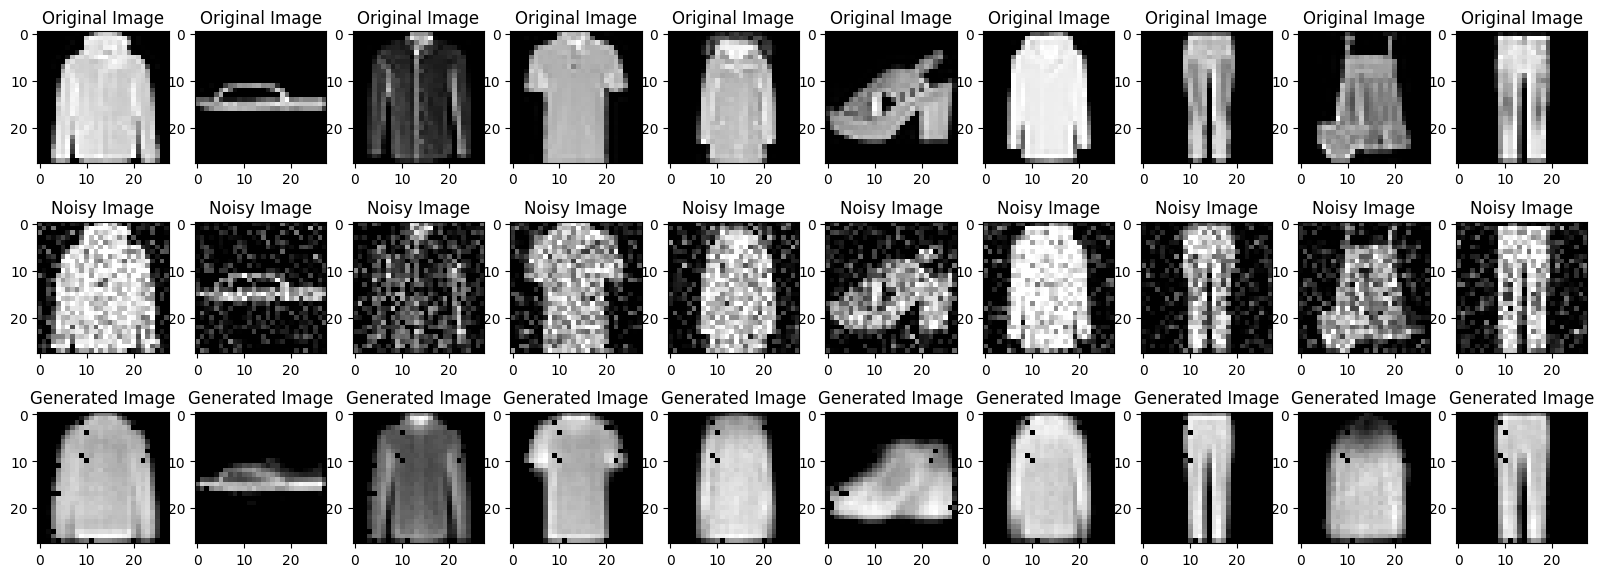

In [12]:

fig = plt.figure(figsize =(20,7))
nrows = 10
b=np.random.randint(0,test_images.shape[0]-nrows)
for i in range(nrows):
    plot = fig.add_subplot( 3,nrows, 0*nrows+i+1)
    plot.set_title('Original Image')
    imgplot = plt.imshow(test_images.view(-1, 28, 28)[b+i].cpu().detach(), cmap='gray')

    plot = fig.add_subplot( 3,nrows,  1*nrows+i+1)
    plot.set_title('Noisy Image')
    imgplot = plt.imshow(noisy_test_imgs.view(-1, 28, 28)[b+i].cpu().detach(), cmap='gray')

    plot = fig.add_subplot( 3,nrows,  2*nrows+i+1)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(test_output.view(-1, 28, 28)[b+i].cpu().detach(), cmap='gray')

plt.show()

In [13]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.manifold import TSNE

## Function to Scale and visualize the embedding vectors
def plot_embedding(X_embed,y, title=None):
    with torch.no_grad():
        X = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=40).fit_transform(X_embed)
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)     
    plt.figure(figsize=(12,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        ## only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 20e-3:
                ## don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(test_images[i].reshape(28,28), cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [14]:
test_embed = model.encoder(test_images.view(-1,784))

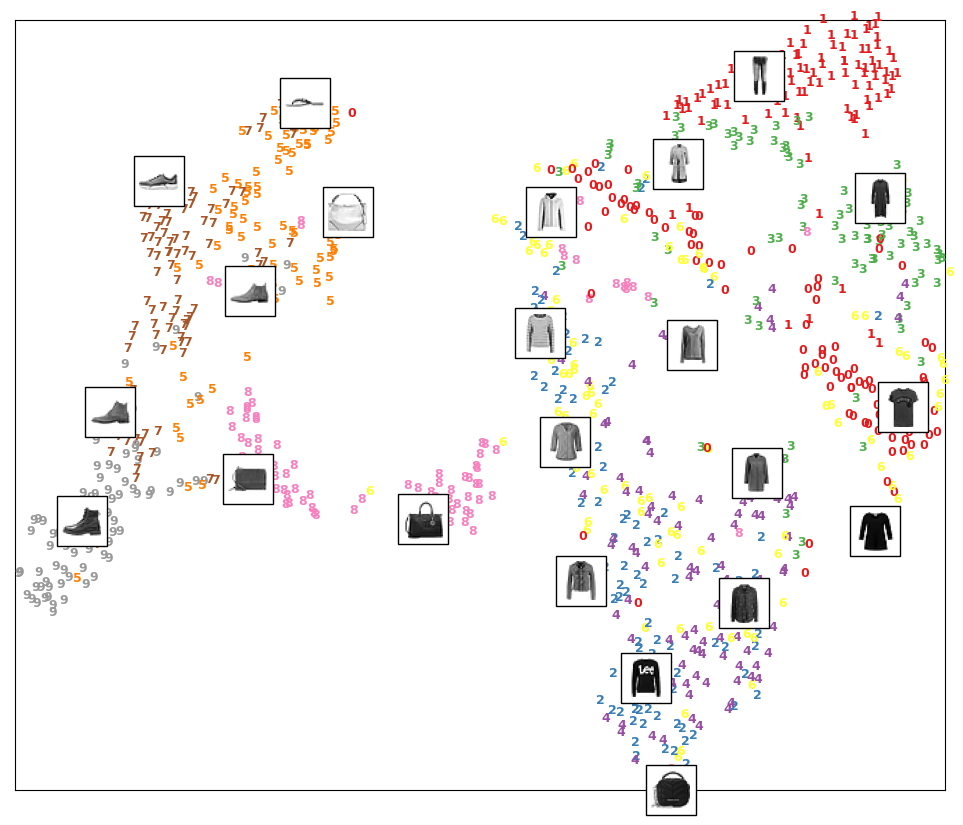

In [15]:

with torch.no_grad():
    plot_embedding(test_embed,test_labels.numpy())

### 1. Use 1 FC layer with Y activation for 10 class classification [4 marks]

##### Roll = M21AIE225
##### X = 4, as last digit of roll no. is odd
##### Y = sigmoid, as last digit of roll no. is odd

In [16]:
freezed_encoder = model.encoder
for p in freezed_encoder.parameters():
    p.requires_grad = False

In [17]:
class SingleFCLayerClassifier(nn.Module):
  def __init__(self):
    super(SingleFCLayerClassifier, self).__init__()
    self.encoder = freezed_encoder

    self.fc_layer = nn.Sequential(
        nn.Linear(64, 10),
        nn.Sigmoid()
        )
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.fc_layer(x)
    return x
     

In [18]:
classifier_1fc = SingleFCLayerClassifier()
print(classifier_1fc)

SingleFCLayerClassifier(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Sigmoid()
  )
)


In [19]:
optimizer_1fc =  torch.optim.Adam(classifier_1fc.parameters(), lr=0.1)
criterion_1fc = nn.CrossEntropyLoss()

In [20]:
epochs = 20

for epoch in range(epochs):
  train_loss = 0.0
  
  for images, labels in trainloader:
            
    # clear the gradients of all optimized variables
    optimizer_1fc.zero_grad()
    ## forward pass: compute predicted outputs by passing *noisy* images to the model
    outputs = classifier_1fc(images.view(-1,784))
    # calculate the loss
    # the "target" is still the original, not-noisy images
    loss = criterion_1fc(outputs, labels)
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer_1fc.step()
    # update running training loss
    train_loss += loss.item()*images.size(0)

  # print avg training statistics 
  train_loss = train_loss/len(trainloader)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

Epoch: 1 	Training Loss: 1758.197586
Epoch: 2 	Training Loss: 1684.934247
Epoch: 3 	Training Loss: 1674.086831
Epoch: 4 	Training Loss: 1663.631292
Epoch: 5 	Training Loss: 1660.667904
Epoch: 6 	Training Loss: 1658.551619
Epoch: 7 	Training Loss: 1657.168682
Epoch: 8 	Training Loss: 1655.781287
Epoch: 9 	Training Loss: 1655.361003
Epoch: 10 	Training Loss: 1654.333117
Epoch: 11 	Training Loss: 1654.084599
Epoch: 12 	Training Loss: 1653.174382
Epoch: 13 	Training Loss: 1652.267929
Epoch: 14 	Training Loss: 1651.690938
Epoch: 15 	Training Loss: 1651.206626
Epoch: 16 	Training Loss: 1650.784524
Epoch: 17 	Training Loss: 1650.611860
Epoch: 18 	Training Loss: 1650.349392
Epoch: 19 	Training Loss: 1649.700443
Epoch: 20 	Training Loss: 1650.340772


In [21]:
test_output_1fc = classifier_1fc(test_images.view(-1,784))

In [22]:
from sklearn import metrics
import seaborn as sns
#sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})

def confusionMatrixAndAccuracyReport(Y_test, Y_pred, label):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = np.trace(cm)/sum(cm.flatten())

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    plt.figure(figsize=(10, 10))
    plt.title('Accuracy Score: {0:3.3f}'.format(overallAccuracy), size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues', fmt='g')

    plt.show()
    print('Overall Accuracy Score: {0:3.3f}'.format(overallAccuracy))
    print('Classwise Accuracy Score: {0}'.format(classwiseAccuracy))

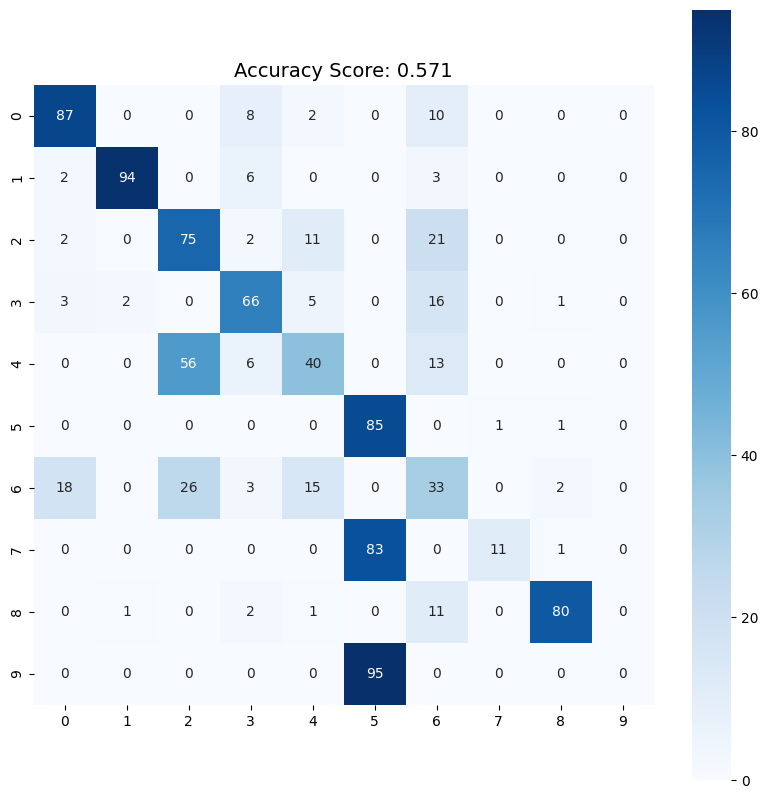

Overall Accuracy Score: 0.571
Classwise Accuracy Score: [0.81308411 0.8952381  0.67567568 0.70967742 0.34782609 0.97701149
 0.34020619 0.11578947 0.84210526 0.        ]


In [23]:
with torch.no_grad():
    confusionMatrixAndAccuracyReport(test_labels,test_output_1fc.argmax(axis=1),testdataset.classes)

In [24]:
class ThreeFCLayerClassifier(nn.Module):
  def __init__(self):
    super(ThreeFCLayerClassifier, self).__init__()
    self.encoder = freezed_encoder

    self.fc_layer = nn.Sequential(
        nn.Linear(64, 32),
        nn.Sigmoid(),
        nn.Linear(32, 16),
        nn.Sigmoid(),
        nn.Linear(16, 10),
        nn.Sigmoid(),
        )
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.fc_layer(x)
    return x
     

In [25]:
classifier_3fc = ThreeFCLayerClassifier()
print(classifier_3fc)

ThreeFCLayerClassifier(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=16, out_features=10, bias=True)
    (5): Sigmoid()
  )
)


In [26]:
optimizer_3fc =  torch.optim.Adam(classifier_3fc.parameters(), lr=0.1)
criterion_3fc = nn.CrossEntropyLoss()

In [27]:
epochs = 20

for epoch in range(epochs):
  train_loss = 0.0
  
  for images, labels in trainloader:
            
    # clear the gradients of all optimized variables
    optimizer_3fc.zero_grad()
    ## forward pass: compute predicted outputs by passing *noisy* images to the model
    outputs = classifier_3fc(images.view(-1,784))
    # calculate the loss
    # the "target" is still the original, not-noisy images
    loss = criterion_3fc(outputs, labels)
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer_3fc.step()
    # update running training loss
    train_loss += loss.item()*images.size(0)

  # print avg training statistics 
  train_loss = train_loss/len(trainloader)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

Epoch: 1 	Training Loss: 1863.297977
Epoch: 2 	Training Loss: 1744.705423
Epoch: 3 	Training Loss: 1731.374737
Epoch: 4 	Training Loss: 1704.290849
Epoch: 5 	Training Loss: 1703.658009
Epoch: 6 	Training Loss: 1699.918151
Epoch: 7 	Training Loss: 1690.099104
Epoch: 8 	Training Loss: 1687.577873
Epoch: 9 	Training Loss: 1687.024568
Epoch: 10 	Training Loss: 1683.965611
Epoch: 11 	Training Loss: 1681.796757
Epoch: 12 	Training Loss: 1649.038664
Epoch: 13 	Training Loss: 1649.082269
Epoch: 14 	Training Loss: 1651.966389
Epoch: 15 	Training Loss: 1648.116225
Epoch: 16 	Training Loss: 1646.579419
Epoch: 17 	Training Loss: 1646.402897
Epoch: 18 	Training Loss: 1646.270406
Epoch: 19 	Training Loss: 1646.260184
Epoch: 20 	Training Loss: 1650.994792


In [28]:
test_output_3fc = classifier_3fc(test_images.view(-1,784))

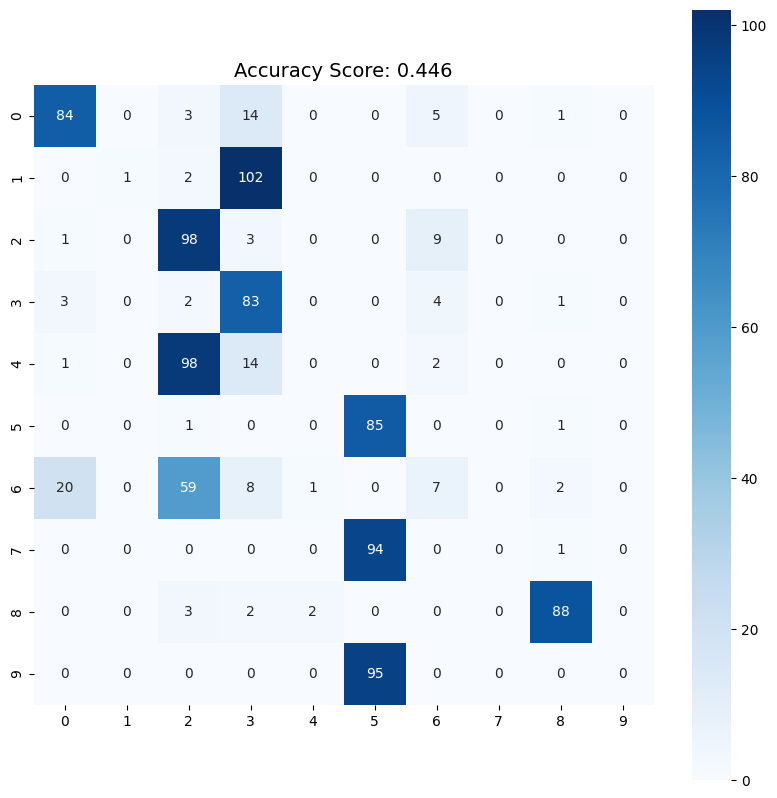

Overall Accuracy Score: 0.446
Classwise Accuracy Score: [0.78504673 0.00952381 0.88288288 0.89247312 0.         0.97701149
 0.07216495 0.         0.92631579 0.        ]


In [29]:
with torch.no_grad():
    confusionMatrixAndAccuracyReport(test_labels,test_output_3fc.argmax(axis=1),testdataset.classes)

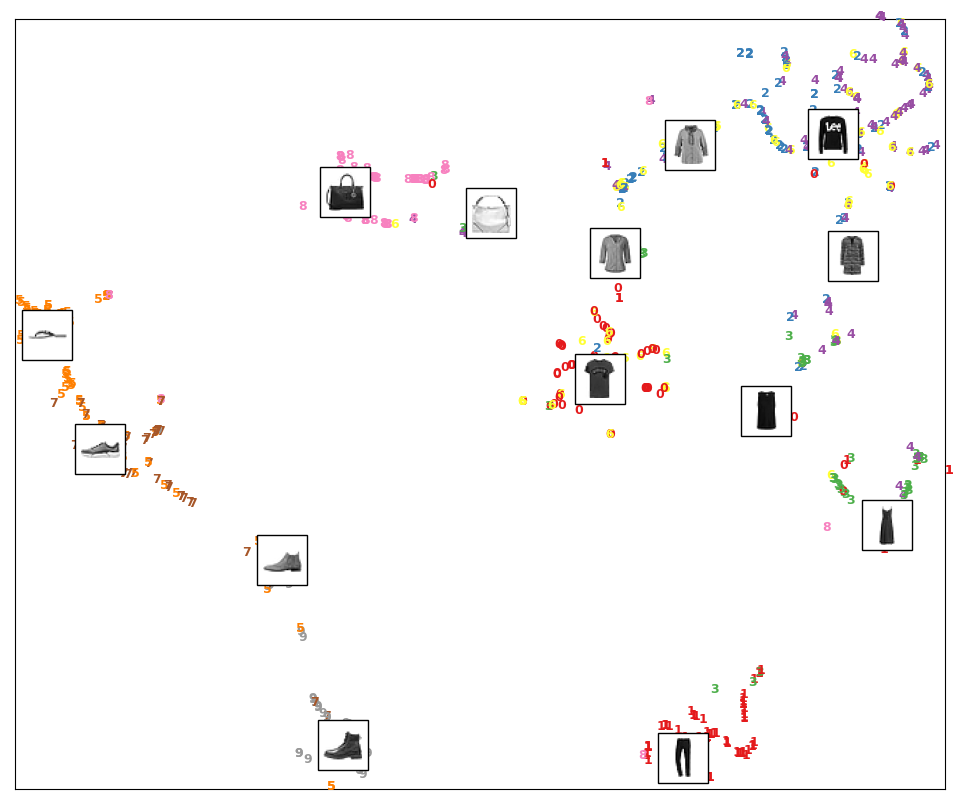

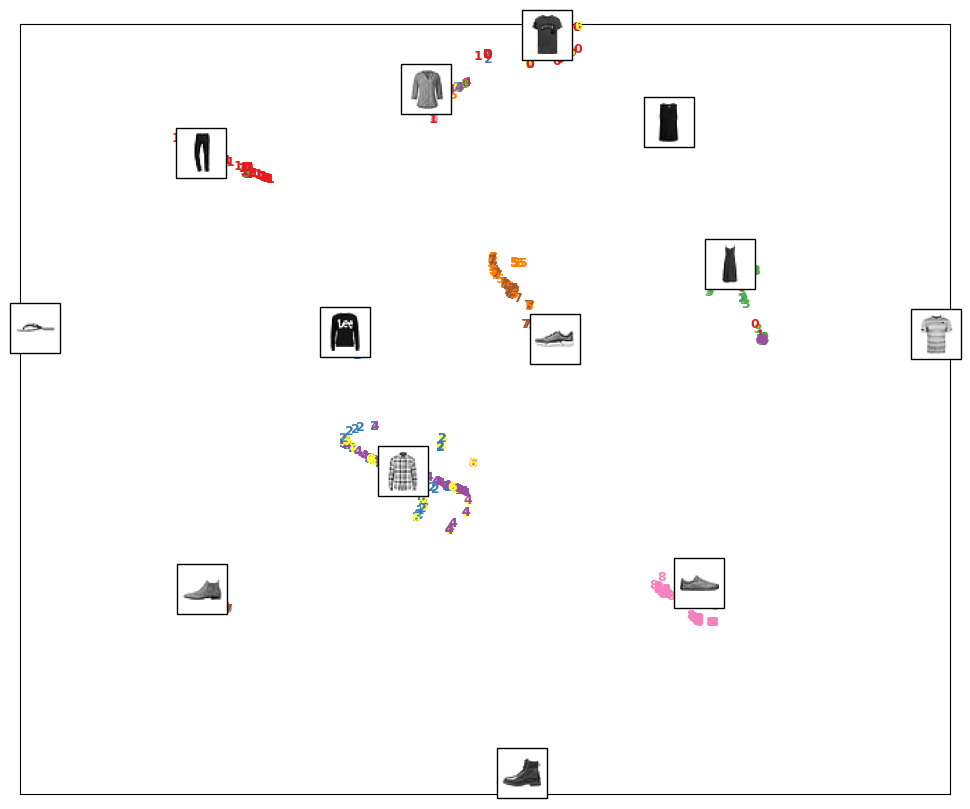

In [32]:
with torch.no_grad():
    plot_embedding(test_output_1fc,test_labels.numpy())
    plot_embedding(test_output_3fc,test_labels.numpy())